### 2. PREDICTION PLAYGROUND [ROMINA|ARG]
___

In [24]:
import os
import spectrai as spa
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from scipy.signal import savgol_filter, resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers, models, Model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model


%load_ext autoreload
%autoreload 2
%matplotlib inline  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Data loading

In [4]:
# Loading
DATA_PATH = os.path.join('..', 'data')
ARGENTINA_PATH =  os.path.join('arg-romina', 'spectra')
ARGENTINA_XRF_URL = os.path.join(DATA_PATH, 'arg-romina', 'measurements', '2015-xrf-results-mean-and-errors.xls')
DATA_URL = os.path.join(DATA_PATH, ARGENTINA_PATH, '*.CSV')

X, X_names, y, y_names, instances_id = spa.load_data_romina(DATA_URL, ARGENTINA_XRF_URL)

In [5]:
#shuf_idx = np.random.RandomState(seed=42).permutation(len(X))
#y = y[shuf_idx,:]
#X = X[shuf_idx,:]

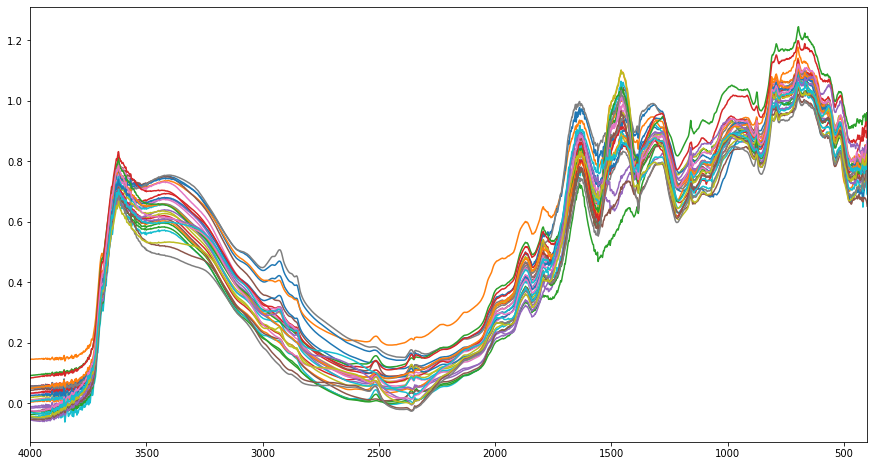

In [6]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlim(4000, 400)
_ = ax.plot(X_names, X.T)

### 2. Partial Least Square Regressions (PLSR)

#### 2.1 Utilities functions

In [7]:
def train_valid_split(data, valid_idx):
    not_valid_idx = np.delete(range(len(data)), valid_idx)
    return (data[not_valid_idx,:], data[valid_idx,:])

def get_analyte(y, names, name):
    list(y_names).index(name)
    return y[:,list(y_names).index(name)]

def assess_model_complexity(X_train, X_valid, y_train, y_valid, analyte, n_comp=10, plot=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse_train = []
    mse_valid = []
    y_train = get_analyte(y_train, y_names, analyte)
    y_valid = get_analyte(y_valid, y_names, analyte)
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        pls.fit(X_train, y_train)
        y_train_pred = pls.predict(X_train)
        y_valid_pred = pls.predict(X_valid)
        mse_train.append(mean_squared_error(y_train, y_train_pred))
        mse_valid.append(mean_squared_error(y_valid, y_valid_pred))

    msemin = np.argmin(mse_valid)
    print('Suggested number of components: ', msemin+1)
    
    pls = PLSRegression(n_components=msemin+1)
    pls.fit(X_train, y_train)
    y_train_pred = pls.predict(X_train)
    y_valid_pred = pls.predict(X_valid)
    score_train = r2_score(y_train, y_train_pred)
    score_valid = r2_score(y_valid, y_valid_pred)
    print('R2 train: %5.3f'  % score_train)
    print('R2 validation: %5.3f'  % score_valid)
    
    if plot is True:
        fig, ax = plt.subplots(figsize=(10,6))
        _ = ax.plot(component, np.array(mse_train), '-v', color = 'blue', mfc='blue')
        _ = ax.plot(component, np.array(mse_valid), '-v', color = 'red', mfc='red')
        plt.xlabel('Number of PLS components')
        plt.ylabel('MSE of predicted {} content'.format(analyte))
        plt.title('Assessing model complexity')
        
    return score_valid   

def optimise_pls_cv(X, y, n_comp=10, cv=20, plot_components=True, analyte='P'):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    y = get_analyte(y, y_names, analyte)
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=cv)
        mse.append(mean_squared_error(y, y_cv))
        #comp = 100*(i+1)/40
        # Trick to update status on the same line
        #stdout.write("\r%d%% completed" % comp)
        #stdout.flush()
    #stdout.write("\n")
    
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    #stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE cross-validation')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
        
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fit to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=cv)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted analyte')
        plt.ylabel('Measured Analyte')
        plt.show()

#### 2.2 Using Romina's validation set

In [8]:
valid_idx = [0, 2, 13, 25, 26, 28, 29]
X_train, X_valid = train_valid_split(X, valid_idx)
y_train, y_valid = train_valid_split(y, valid_idx)

##### 2.2.1 No preprocessing + all wavenumbers

Suggested number of components:  4
R2 train: 0.629
R2 validation: 0.795


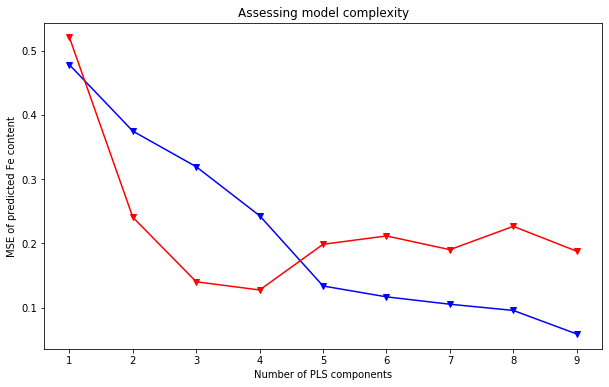

In [9]:
r2_valid = assess_model_complexity(X_train, X_valid, y_train, y_valid, 'Fe', n_comp=10)

##### 2.2.2 Preprocessing + all wavenumbers

Suggested number of components:  1
R2 train: 0.676
R2 validation: 0.199


0.19892527285977224

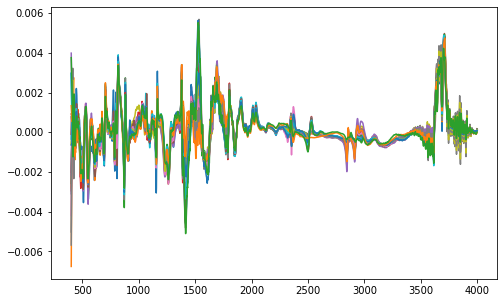

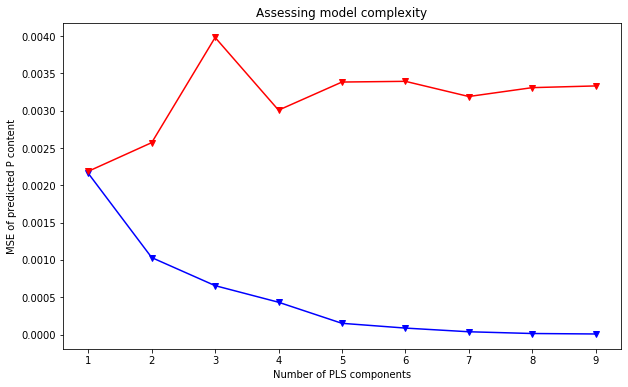

In [10]:
X1_train = savgol_filter(X_train, 25, polyorder = 2, deriv=1)
X1_valid = savgol_filter(X_valid, 25, polyorder = 2, deriv=1)

fig, ax = plt.subplots(figsize=(8,5))
_ = ax.plot(X_names, X1_train.T)

assess_model_complexity(X1_train, X1_valid, y_train, y_valid, 'P', n_comp=10)

##### 2.2.3 No preprocessing + selected wavenumbers

In [11]:
windows = (((X_names >= 508.63) & (X_names <= 578.54)) |
          ((X_names >= 766.08) & (X_names <= 2200)) |
          ((X_names >= 2400) & (X_names <= 3851.15)))

In [12]:
input_dim = X.shape[1]Xw_train = X_train[:,windows]
Xw_valid = X_valid[:,windows]

assess_model_complexity(Xw_train, Xw_valid, y_train, y_valid, 'P', n_comp=10)

SyntaxError: invalid syntax (<ipython-input-12-bbf25541cfa6>, line 1)

##### 2.2.4 Preprocessing + selected wavenumbers

Suggested number of components:  4
R2 train: 0.905
R2 validation: 0.923


0.9225523316857791

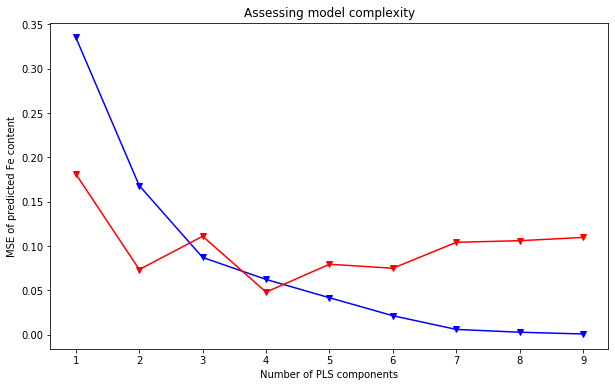

In [13]:
X1_train = savgol_filter(X_train, 11, polyorder = 1, deriv=1)
X1_valid = savgol_filter(X_valid, 11, polyorder = 1, deriv=1)

X1w_train = X1_train[:,windows]
X1w_valid = X1_valid[:,windows]

assess_model_complexity(X1w_train, X1w_valid, y_train, y_valid, 'Fe', n_comp=10)

#### 2.3 Using K-fold cross-validation

##### 2.3.1 Preprocessing + selected wavenumbers

Suggested number of components:  1


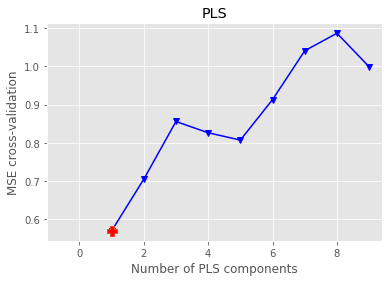

R2 calib: 0.544
R2 CV: 0.127
MSE calib: 0.298
MSE CV: 0.570


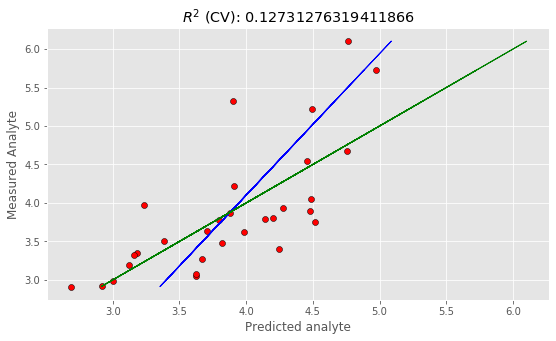

In [14]:
# With cross-validation
X1_all = savgol_filter(X, 11, polyorder = 1, deriv=1)

X1w_all = X1_all[:,windows]

optimise_pls_cv(X1w_all, y, n_comp=10, cv=3, plot_components=True, analyte='Fe')

In [ ]:
# Pre_processing steps grid search
scores = []
window_lengths = []
polyorders = []

for p in list(range(1,10,2)):
    for w in list(range(11,211,20)):
        X1_train = savgol_filter(X_train, w, polyorder = p, deriv=1)
        X1_valid = savgol_filter(X_valid, w, polyorder = p, deriv=1)
        scores.append(assess_model_complexity(X1_train, X1_valid, y_train, y_valid, 'Ba', n_comp=10, plot=False))
        window_lengths.append(w)
        polyorders.append(p)

best_score_idx = np.argmax(scores)
print('*'*100)
print('Best R2 validation: %5.3f'  % scores[best_score_idx])
print('With Savgol filter window length: {}'.format(window_lengths[best_score_idx]))
print('With Savgol filter polyorder: {}'.format(polyorders[best_score_idx]))

### 3. Convolutional Neural Networks (CNN)

#### 3.1 Utilities functions

In [16]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def standardize(X):
    return (X - X.mean()) - X.std()

def normalize(X):
    return (X - X.min()) / (X.max() - X.min())

In [61]:
# Troubleshooting keras reshape
input_dim = X.shape[1]
model = keras.models.Sequential()
model.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))
model.compile(optimizer=RMSprop(), loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 7467, 1)           0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


#### 3.2 Effect of convolution/pooling layers on 1D data

In [62]:
t = np.zeros(1000)
t[t.shape[0]//2] = 1
one_among_many = t

In [ ]:
input_dim = X.shape[1]

#my_weights = np.array([1, 1, 1, 0]).reshape(-1,1,1)
#my_weights = np.random.random(1000).reshape(-1,1,1)
#my_weights = np.ones(1000).reshape(-1,1,1)
my_weights = np.array([i % 10 for i in range(100)]).reshape(-1,1,1)
#my_weights = np.array(one_among_many).reshape(-1,1,1)
my_bias = np.array([0.], dtype=np.float32)

model_conv = keras.models.Sequential()
model_conv.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))
model_conv.add(layers.Conv1D(1, my_weights.shape[0], weights=[my_weights, my_bias], activation='relu'))
model_conv.summary()
model_conv.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')

conv_layer_name = [layer for  layer in model_conv.layers][1].name
vis_kernels(model_conv, conv_layer_name, cmap='Greys', width=8)

fig, ax = plt.subplots(figsize=(20,4))
_ = ax.plot(model_conv.predict(normalize(X_train))[0])

#### 3.3 Single channel 1D CNN

In [20]:
activation = 'relu'
input_dim = X.shape[1]

model = keras.models.Sequential()
model.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

model.add(layers.Conv1D(32, 30, activation=activation))
model.add(layers.MaxPool1D(10))

model.add(layers.Conv1D(64, 30, activation=activation))
model.add(layers.MaxPool1D(10))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation=activation))
model.add(layers.Dense(50, activation=activation))
model.add(layers.Dense(10, activation=activation))
model.add(layers.Dense(1,  activation='linear'))

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=[coeff_determination])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 7467, 1)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7438, 32)          992       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 743, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 714, 64)           61504     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 71, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4544)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

##### 3.3.1 Fitting and validating on Romina's training/validation sets

In [21]:
analyte = 'Fe'

valid_idx = [0, 2, 13, 25, 26, 28, 29]
X_train, X_valid = train_valid_split(X, valid_idx)
y_train, y_valid = train_valid_split(y, valid_idx)

y_train_nn = get_analyte(y_train, y_names, analyte)
y_valid_nn = get_analyte(y_valid, y_names, analyte)

history = model.fit(normalize(X_train), y_train_nn, epochs=2000, validation_data=(normalize(X_valid), y_valid_nn))

Train on 23 samples, validate on 7 samples
Epoch 1/2000
23/23 [==============================] - 1s 41ms/sample - loss: 14.9935 - coeff_determination: -21.8745 - val_loss: 7.5470 - val_coeff_determination: -11.1300
Epoch 2/2000
23/23 [==============================] - 0s 7ms/sample - loss: 6.9354 - coeff_determination: -9.5807 - val_loss: 34.3252 - val_coeff_determination: -54.1691
Epoch 3/2000
23/23 [==============================] - 0s 8ms/sample - loss: 32.1308 - coeff_determination: -48.0194 - val_loss: 5.5257 - val_coeff_determination: -7.8811
Epoch 4/2000
23/23 [==============================] - 0s 11ms/sample - loss: 5.0731 - coeff_determination: -6.7397 - val_loss: 2.2531 - val_coeff_determination: -2.6212
Epoch 5/2000
23/23 [==============================] - 0s 12ms/sample - loss: 2.0339 - coeff_determination: -2.1029 - val_loss: 0.7776 - val_coeff_determination: -0.2499
Epoch 6/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.6862 - coeff_determination: 

Epoch 50/2000
23/23 [==============================] - 0s 10ms/sample - loss: 1.5886 - coeff_determination: -1.4236 - val_loss: 1.2329 - val_coeff_determination: -0.9815
Epoch 51/2000
23/23 [==============================] - 0s 8ms/sample - loss: 1.1244 - coeff_determination: -0.7154 - val_loss: 1.7342 - val_coeff_determination: -1.7872
Epoch 52/2000
23/23 [==============================] - 0s 7ms/sample - loss: 1.5970 - coeff_determination: -1.4364 - val_loss: 1.2566 - val_coeff_determination: -1.0197
Epoch 53/2000
23/23 [==============================] - 0s 7ms/sample - loss: 1.1465 - coeff_determination: -0.7491 - val_loss: 1.7634 - val_coeff_determination: -1.8342
Epoch 54/2000
23/23 [==============================] - 0s 8ms/sample - loss: 1.6252 - coeff_determination: -1.4794 - val_loss: 1.2297 - val_coeff_determination: -0.9765
Epoch 55/2000
23/23 [==============================] - 0s 7ms/sample - loss: 1.1220 - coeff_determination: -0.7117 - val_loss: 1.6925 - val_coeff_determin

Epoch 99/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.9773 - coeff_determination: -0.4909 - val_loss: 1.3009 - val_coeff_determination: -1.0909
Epoch 100/2000
23/23 [==============================] - 0s 9ms/sample - loss: 1.2136 - coeff_determination: -0.8515 - val_loss: 1.0305 - val_coeff_determination: -0.6563
Epoch 101/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.9450 - coeff_determination: -0.4418 - val_loss: 1.2569 - val_coeff_determination: -1.0201
Epoch 102/2000
23/23 [==============================] - 0s 9ms/sample - loss: 1.1731 - coeff_determination: -0.7897 - val_loss: 1.0403 - val_coeff_determination: -0.6720
Epoch 103/2000
23/23 [==============================] - 0s 13ms/sample - loss: 0.9536 - coeff_determination: -0.4549 - val_loss: 1.2890 - val_coeff_determination: -1.0718
Epoch 104/2000
23/23 [==============================] - 0s 8ms/sample - loss: 1.2041 - coeff_determination: -0.8370 - val_loss: 1.0291 - val_coeff_det

Epoch 148/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.9893 - coeff_determination: -0.5093 - val_loss: 1.1000 - val_coeff_determination: -0.7679
Epoch 149/2000
23/23 [==============================] - 0s 8ms/sample - loss: 1.0112 - coeff_determination: -0.5427 - val_loss: 1.5454 - val_coeff_determination: -1.4839
Epoch 150/2000
23/23 [==============================] - 0s 13ms/sample - loss: 1.4573 - coeff_determination: -1.2233 - val_loss: 1.0919 - val_coeff_determination: -0.7549
Epoch 151/2000
23/23 [==============================] - 0s 9ms/sample - loss: 1.0040 - coeff_determination: -0.5317 - val_loss: 1.3810 - val_coeff_determination: -1.2197
Epoch 152/2000
23/23 [==============================] - 0s 10ms/sample - loss: 1.3042 - coeff_determination: -0.9896 - val_loss: 0.9780 - val_coeff_determination: -0.5719
Epoch 153/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.9011 - coeff_determination: -0.3748 - val_loss: 1.1413 - val_coeff

Epoch 197/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.8408 - coeff_determination: -0.2828 - val_loss: 1.0355 - val_coeff_determination: -0.6642
Epoch 198/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.9908 - coeff_determination: -0.5116 - val_loss: 0.8948 - val_coeff_determination: -0.4382
Epoch 199/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.8297 - coeff_determination: -0.2657 - val_loss: 1.0147 - val_coeff_determination: -0.6308
Epoch 200/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.9716 - coeff_determination: -0.4822 - val_loss: 0.8879 - val_coeff_determination: -0.4271
Epoch 201/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.8235 - coeff_determination: -0.2563 - val_loss: 1.0080 - val_coeff_determination: -0.6201
Epoch 202/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.9659 - coeff_determination: -0.4736 - val_loss: 0.8902 - val_coeff_det

Epoch 246/2000
23/23 [==============================] - 0s 13ms/sample - loss: 0.8874 - coeff_determination: -0.3538 - val_loss: 0.8570 - val_coeff_determination: -0.3775
Epoch 247/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.7979 - coeff_determination: -0.2173 - val_loss: 0.9823 - val_coeff_determination: -0.5788
Epoch 248/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.9464 - coeff_determination: -0.4439 - val_loss: 0.8669 - val_coeff_determination: -0.3934
Epoch 249/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.8068 - coeff_determination: -0.2308 - val_loss: 0.9820 - val_coeff_determination: -0.5784
Epoch 250/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.9465 - coeff_determination: -0.4440 - val_loss: 0.8492 - val_coeff_determination: -0.3649
Epoch 251/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.7913 - coeff_determination: -0.2073 - val_loss: 0.9445 - val_coeff_

Epoch 295/2000
23/23 [==============================] - 0s 13ms/sample - loss: 0.7480 - coeff_determination: -0.1412 - val_loss: 0.8813 - val_coeff_determination: -0.4165
Epoch 296/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.8583 - coeff_determination: -0.3095 - val_loss: 0.7976 - val_coeff_determination: -0.2820
Epoch 297/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.7496 - coeff_determination: -0.1436 - val_loss: 0.8783 - val_coeff_determination: -0.4117
Epoch 298/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.8552 - coeff_determination: -0.3046 - val_loss: 0.7884 - val_coeff_determination: -0.2672
Epoch 299/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.7417 - coeff_determination: -0.1315 - val_loss: 0.8709 - val_coeff_determination: -0.3997
Epoch 300/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.8489 - coeff_determination: -0.2951 - val_loss: 0.7899 - val_coeff_de

23/23 [==============================] - 0s 8ms/sample - loss: 0.6931 - coeff_determination: -0.0574 - val_loss: 0.7920 - val_coeff_determination: -0.2730
Epoch 344/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.7787 - coeff_determination: -0.1880 - val_loss: 0.7442 - val_coeff_determination: -0.1961
Epoch 345/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.7074 - coeff_determination: -0.0792 - val_loss: 0.8181 - val_coeff_determination: -0.3150
Epoch 346/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.8036 - coeff_determination: -0.2259 - val_loss: 0.7514 - val_coeff_determination: -0.2077
Epoch 347/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.7138 - coeff_determination: -0.0890 - val_loss: 0.8230 - val_coeff_determination: -0.3227
Epoch 348/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.8078 - coeff_determination: -0.2325 - val_loss: 0.7437 - val_coeff_determination: -0.

Epoch 392/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.7491 - coeff_determination: -0.1429 - val_loss: 0.6965 - val_coeff_determination: -0.1195
Epoch 393/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.6692 - coeff_determination: -0.0210 - val_loss: 0.7507 - val_coeff_determination: -0.2065
Epoch 394/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.7423 - coeff_determination: -0.1324 - val_loss: 0.6945 - val_coeff_determination: -0.1162
Epoch 395/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.6680 - coeff_determination: -0.0191 - val_loss: 0.7500 - val_coeff_determination: -0.2054
Epoch 396/2000
23/23 [==============================] - 0s 13ms/sample - loss: 0.7421 - coeff_determination: -0.1322 - val_loss: 0.6890 - val_coeff_determination: -0.1074
Epoch 397/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.6636 - coeff_determination: -0.0124 - val_loss: 0.7637 - val_coeff_de

Epoch 441/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.6364 - coeff_determination: 0.0291 - val_loss: 0.7065 - val_coeff_determination: -0.1355
Epoch 442/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.7014 - coeff_determination: -0.0700 - val_loss: 0.6554 - val_coeff_determination: -0.0533
Epoch 443/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.6318 - coeff_determination: 0.0361 - val_loss: 0.6951 - val_coeff_determination: -0.1172
Epoch 444/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.6929 - coeff_determination: -0.0570 - val_loss: 0.6528 - val_coeff_determination: -0.0493
Epoch 445/2000
23/23 [==============================] - 0s 13ms/sample - loss: 0.6294 - coeff_determination: 0.0397 - val_loss: 0.6978 - val_coeff_determination: -0.1215
Epoch 446/2000
23/23 [==============================] - 0s 13ms/sample - loss: 0.6939 - coeff_determination: -0.0586 - val_loss: 0.6530 - val_coeff_det

Epoch 490/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.6655 - coeff_determination: -0.0153 - val_loss: 0.6195 - val_coeff_determination: 0.0044
Epoch 491/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.6012 - coeff_determination: 0.0828 - val_loss: 0.6621 - val_coeff_determination: -0.0642
Epoch 492/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.6639 - coeff_determination: -0.0129 - val_loss: 0.6202 - val_coeff_determination: 0.0032
Epoch 493/2000
23/23 [==============================] - 0s 15ms/sample - loss: 0.6029 - coeff_determination: 0.0802 - val_loss: 0.6794 - val_coeff_determination: -0.0920
Epoch 494/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.6798 - coeff_determination: -0.0372 - val_loss: 0.6305 - val_coeff_determination: -0.0134
Epoch 495/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.6111 - coeff_determination: 0.0677 - val_loss: 0.6732 - val_coeff_determi

Epoch 539/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.5721 - coeff_determination: 0.1272 - val_loss: 0.5314 - val_coeff_determination: 0.1459
Epoch 540/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.5387 - coeff_determination: 0.1782 - val_loss: 0.4815 - val_coeff_determination: 0.2262
Epoch 541/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4833 - coeff_determination: 0.2627 - val_loss: 0.4640 - val_coeff_determination: 0.2542
Epoch 542/2000
23/23 [==============================] - 0s 12ms/sample - loss: 0.4755 - coeff_determination: 0.2746 - val_loss: 0.4565 - val_coeff_determination: 0.2664
Epoch 543/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4639 - coeff_determination: 0.2922 - val_loss: 0.4603 - val_coeff_determination: 0.2602
Epoch 544/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4736 - coeff_determination: 0.2774 - val_loss: 0.4785 - val_coeff_determination

Epoch 588/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.6320 - coeff_determination: 0.0358 - val_loss: 0.5650 - val_coeff_determination: 0.0920
Epoch 589/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5685 - coeff_determination: 0.1326 - val_loss: 0.6349 - val_coeff_determination: -0.0205
Epoch 590/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.6313 - coeff_determination: 0.0368 - val_loss: 0.5658 - val_coeff_determination: 0.0905
Epoch 591/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.5690 - coeff_determination: 0.1319 - val_loss: 0.6369 - val_coeff_determination: -0.0236
Epoch 592/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.6330 - coeff_determination: 0.0343 - val_loss: 0.5636 - val_coeff_determination: 0.0941
Epoch 593/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5660 - coeff_determination: 0.1365 - val_loss: 0.7022 - val_coeff_determinatio

Epoch 637/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5366 - coeff_determination: 0.1813 - val_loss: 0.5849 - val_coeff_determination: 0.0599
Epoch 638/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5784 - coeff_determination: 0.1176 - val_loss: 0.4991 - val_coeff_determination: 0.1978
Epoch 639/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5193 - coeff_determination: 0.2078 - val_loss: 0.5710 - val_coeff_determination: 0.0823
Epoch 640/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5663 - coeff_determination: 0.1361 - val_loss: 0.5073 - val_coeff_determination: 0.1846
Epoch 641/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5275 - coeff_determination: 0.1952 - val_loss: 0.5987 - val_coeff_determination: 0.0378
Epoch 642/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5913 - coeff_determination: 0.0979 - val_loss: 0.5316 - val_coeff_determination:

Epoch 686/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.5941 - coeff_determination: 0.0936 - val_loss: 0.5003 - val_coeff_determination: 0.1959
Epoch 687/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5288 - coeff_determination: 0.1932 - val_loss: 0.5973 - val_coeff_determination: 0.0399
Epoch 688/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.5850 - coeff_determination: 0.1076 - val_loss: 0.4918 - val_coeff_determination: 0.2095
Epoch 689/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5213 - coeff_determination: 0.2046 - val_loss: 0.5854 - val_coeff_determination: 0.0592
Epoch 690/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5742 - coeff_determination: 0.1240 - val_loss: 0.4854 - val_coeff_determination: 0.2199
Epoch 691/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5158 - coeff_determination: 0.2132 - val_loss: 0.5804 - val_coeff_determination:

Epoch 735/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.5018 - coeff_determination: 0.2344 - val_loss: 0.5703 - val_coeff_determination: 0.0834
Epoch 736/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.5574 - coeff_determination: 0.1496 - val_loss: 0.4577 - val_coeff_determination: 0.2643
Epoch 737/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.5024 - coeff_determination: 0.2335 - val_loss: 0.5698 - val_coeff_determination: 0.0842
Epoch 738/2000
23/23 [==============================] - 0s 13ms/sample - loss: 0.5561 - coeff_determination: 0.1515 - val_loss: 0.4558 - val_coeff_determination: 0.2675
Epoch 739/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5016 - coeff_determination: 0.2348 - val_loss: 0.5687 - val_coeff_determination: 0.0860
Epoch 740/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.5524 - coeff_determination: 0.1573 - val_loss: 0.4599 - val_coeff_determinat

Epoch 784/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5323 - coeff_determination: 0.1879 - val_loss: 0.4331 - val_coeff_determination: 0.3039
Epoch 785/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4881 - coeff_determination: 0.2554 - val_loss: 0.5583 - val_coeff_determination: 0.1026
Epoch 786/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.5390 - coeff_determination: 0.1777 - val_loss: 0.4280 - val_coeff_determination: 0.3120
Epoch 787/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4857 - coeff_determination: 0.2590 - val_loss: 0.5580 - val_coeff_determination: 0.1032
Epoch 788/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.5383 - coeff_determination: 0.1788 - val_loss: 0.4393 - val_coeff_determination: 0.2939
Epoch 789/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.4937 - coeff_determination: 0.2467 - val_loss: 0.5638 - val_coeff_determination:

Epoch 833/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4804 - coeff_determination: 0.2671 - val_loss: 0.5588 - val_coeff_determination: 0.1019
Epoch 834/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5331 - coeff_determination: 0.1867 - val_loss: 0.4040 - val_coeff_determination: 0.3507
Epoch 835/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4719 - coeff_determination: 0.2801 - val_loss: 0.5402 - val_coeff_determination: 0.1318
Epoch 836/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.5174 - coeff_determination: 0.2106 - val_loss: 0.3993 - val_coeff_determination: 0.3583
Epoch 837/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4702 - coeff_determination: 0.2827 - val_loss: 0.5421 - val_coeff_determination: 0.1288
Epoch 838/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.5179 - coeff_determination: 0.2098 - val_loss: 0.3993 - val_coeff_determination

Epoch 882/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5106 - coeff_determination: 0.2210 - val_loss: 0.3809 - val_coeff_determination: 0.3878
Epoch 883/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4600 - coeff_determination: 0.2983 - val_loss: 0.5302 - val_coeff_determination: 0.1478
Epoch 884/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5052 - coeff_determination: 0.2292 - val_loss: 0.3820 - val_coeff_determination: 0.3860
Epoch 885/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4599 - coeff_determination: 0.2984 - val_loss: 0.5298 - val_coeff_determination: 0.1486
Epoch 886/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5063 - coeff_determination: 0.2276 - val_loss: 0.3803 - val_coeff_determination: 0.3887
Epoch 887/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4604 - coeff_determination: 0.2975 - val_loss: 0.5343 - val_coeff_determination:

Epoch 931/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.4566 - coeff_determination: 0.3034 - val_loss: 0.5315 - val_coeff_determination: 0.1457
Epoch 932/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5066 - coeff_determination: 0.2271 - val_loss: 0.3757 - val_coeff_determination: 0.3962
Epoch 933/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4596 - coeff_determination: 0.2988 - val_loss: 0.5266 - val_coeff_determination: 0.1536
Epoch 934/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.5011 - coeff_determination: 0.2355 - val_loss: 0.3782 - val_coeff_determination: 0.3921
Epoch 935/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4662 - coeff_determination: 0.2887 - val_loss: 0.5634 - val_coeff_determination: 0.0945
Epoch 936/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5316 - coeff_determination: 0.1890 - val_loss: 0.3647 - val_coeff_determinatio

Epoch 980/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.4808 - coeff_determination: 0.2666 - val_loss: 0.3549 - val_coeff_determination: 0.4296
Epoch 981/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.4489 - coeff_determination: 0.3151 - val_loss: 0.5266 - val_coeff_determination: 0.1536
Epoch 982/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.5002 - coeff_determination: 0.2368 - val_loss: 0.3518 - val_coeff_determination: 0.4346
Epoch 983/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4465 - coeff_determination: 0.3188 - val_loss: 0.5200 - val_coeff_determination: 0.1642
Epoch 984/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.4941 - coeff_determination: 0.2462 - val_loss: 0.3528 - val_coeff_determination: 0.4329
Epoch 985/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4463 - coeff_determination: 0.3191 - val_loss: 0.5138 - val_coeff_determination

Epoch 1029/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4360 - coeff_determination: 0.3349 - val_loss: 0.5044 - val_coeff_determination: 0.1893
Epoch 1030/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4770 - coeff_determination: 0.2722 - val_loss: 0.3312 - val_coeff_determination: 0.4676
Epoch 1031/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.4261 - coeff_determination: 0.3499 - val_loss: 0.4850 - val_coeff_determination: 0.2205
Epoch 1032/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.4641 - coeff_determination: 0.2920 - val_loss: 0.3281 - val_coeff_determination: 0.4726
Epoch 1033/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4243 - coeff_determination: 0.3526 - val_loss: 0.4950 - val_coeff_determination: 0.2045
Epoch 1034/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.4683 - coeff_determination: 0.2855 - val_loss: 0.3405 - val_coeff_determin

Epoch 1078/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.4748 - coeff_determination: 0.2756 - val_loss: 0.3239 - val_coeff_determination: 0.4794
Epoch 1079/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4263 - coeff_determination: 0.3496 - val_loss: 0.5008 - val_coeff_determination: 0.1951
Epoch 1080/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.4720 - coeff_determination: 0.2799 - val_loss: 0.3342 - val_coeff_determination: 0.4629
Epoch 1081/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4336 - coeff_determination: 0.3386 - val_loss: 0.5036 - val_coeff_determination: 0.1906
Epoch 1082/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.4769 - coeff_determination: 0.2724 - val_loss: 0.3226 - val_coeff_determination: 0.4815
Epoch 1083/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.4215 - coeff_determination: 0.3570 - val_loss: 0.4848 - val_coeff_determi

Epoch 1127/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.4119 - coeff_determination: 0.3716 - val_loss: 0.4785 - val_coeff_determination: 0.2309
Epoch 1128/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4568 - coeff_determination: 0.3031 - val_loss: 0.3254 - val_coeff_determination: 0.4771
Epoch 1129/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.4282 - coeff_determination: 0.3467 - val_loss: 0.4943 - val_coeff_determination: 0.2055
Epoch 1130/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.4689 - coeff_determination: 0.2846 - val_loss: 0.3087 - val_coeff_determination: 0.5038
Epoch 1131/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4119 - coeff_determination: 0.3716 - val_loss: 0.4775 - val_coeff_determination: 0.2325
Epoch 1132/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4495 - coeff_determination: 0.3142 - val_loss: 0.3044 - val_coeff_determin

Epoch 1176/2000
23/23 [==============================] - 0s 12ms/sample - loss: 0.4520 - coeff_determination: 0.3104 - val_loss: 0.2978 - val_coeff_determination: 0.5214
Epoch 1177/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.4025 - coeff_determination: 0.3860 - val_loss: 0.4649 - val_coeff_determination: 0.2528
Epoch 1178/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.4415 - coeff_determination: 0.3264 - val_loss: 0.3035 - val_coeff_determination: 0.5121
Epoch 1179/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4109 - coeff_determination: 0.3731 - val_loss: 0.4757 - val_coeff_determination: 0.2354
Epoch 1180/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4484 - coeff_determination: 0.3160 - val_loss: 0.3240 - val_coeff_determination: 0.4792
Epoch 1181/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4323 - coeff_determination: 0.3405 - val_loss: 0.5394 - val_coeff_determ

Epoch 1225/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3939 - coeff_determination: 0.3991 - val_loss: 0.4485 - val_coeff_determination: 0.2791
Epoch 1226/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.4285 - coeff_determination: 0.3463 - val_loss: 0.2876 - val_coeff_determination: 0.5378
Epoch 1227/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3948 - coeff_determination: 0.3977 - val_loss: 0.4564 - val_coeff_determination: 0.2665
Epoch 1228/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4329 - coeff_determination: 0.3395 - val_loss: 0.3004 - val_coeff_determination: 0.5172
Epoch 1229/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.4042 - coeff_determination: 0.3833 - val_loss: 0.4660 - val_coeff_determination: 0.2510
Epoch 1230/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4423 - coeff_determination: 0.3252 - val_loss: 0.2849 - val_coeff_determin

Epoch 1274/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.4289 - coeff_determination: 0.3457 - val_loss: 0.2822 - val_coeff_determination: 0.5465
Epoch 1275/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.3911 - coeff_determination: 0.4033 - val_loss: 0.4582 - val_coeff_determination: 0.2635
Epoch 1276/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.4293 - coeff_determination: 0.3450 - val_loss: 0.2826 - val_coeff_determination: 0.5458
Epoch 1277/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.3916 - coeff_determination: 0.4026 - val_loss: 0.4545 - val_coeff_determination: 0.2695
Epoch 1278/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4280 - coeff_determination: 0.3471 - val_loss: 0.2846 - val_coeff_determination: 0.5426
Epoch 1279/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.3923 - coeff_determination: 0.4015 - val_loss: 0.4512 - val_coeff_deter

Epoch 1323/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.3968 - coeff_determination: 0.3946 - val_loss: 0.4673 - val_coeff_determination: 0.2490
Epoch 1324/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4323 - coeff_determination: 0.3404 - val_loss: 0.2730 - val_coeff_determination: 0.5612
Epoch 1325/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3803 - coeff_determination: 0.4198 - val_loss: 0.4421 - val_coeff_determination: 0.2894
Epoch 1326/2000
23/23 [==============================] - 0s 12ms/sample - loss: 0.4206 - coeff_determination: 0.3583 - val_loss: 0.2853 - val_coeff_determination: 0.5414
Epoch 1327/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.3983 - coeff_determination: 0.3923 - val_loss: 0.4663 - val_coeff_determination: 0.2505
Epoch 1328/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.4305 - coeff_determination: 0.3433 - val_loss: 0.2696 - val_coeff_deter

Epoch 1372/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4056 - coeff_determination: 0.3812 - val_loss: 0.2789 - val_coeff_determination: 0.5517
Epoch 1373/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.3898 - coeff_determination: 0.4053 - val_loss: 0.4570 - val_coeff_determination: 0.2655
Epoch 1374/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.4254 - coeff_determination: 0.3510 - val_loss: 0.2674 - val_coeff_determination: 0.5702
Epoch 1375/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3743 - coeff_determination: 0.4290 - val_loss: 0.4462 - val_coeff_determination: 0.2829
Epoch 1376/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.4066 - coeff_determination: 0.3796 - val_loss: 0.2663 - val_coeff_determination: 0.5720
Epoch 1377/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3757 - coeff_determination: 0.4268 - val_loss: 0.4458 - val_coeff_determi

Epoch 1421/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3892 - coeff_determination: 0.4062 - val_loss: 0.4868 - val_coeff_determination: 0.2176
Epoch 1422/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.4302 - coeff_determination: 0.3437 - val_loss: 0.2647 - val_coeff_determination: 0.5745
Epoch 1423/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.3788 - coeff_determination: 0.4222 - val_loss: 0.4696 - val_coeff_determination: 0.2452
Epoch 1424/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4198 - coeff_determination: 0.3595 - val_loss: 0.2684 - val_coeff_determination: 0.5686
Epoch 1425/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.3757 - coeff_determination: 0.4268 - val_loss: 0.4451 - val_coeff_determination: 0.2846
Epoch 1426/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.4043 - coeff_determination: 0.3833 - val_loss: 0.2582 - val_coeff_determ

Epoch 1470/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.4222 - coeff_determination: 0.3559 - val_loss: 0.2823 - val_coeff_determination: 0.5463
Epoch 1471/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3753 - coeff_determination: 0.4274 - val_loss: 0.4706 - val_coeff_determination: 0.2436
Epoch 1472/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.3967 - coeff_determination: 0.3948 - val_loss: 0.2432 - val_coeff_determination: 0.6092
Epoch 1473/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.3456 - coeff_determination: 0.4727 - val_loss: 0.4190 - val_coeff_determination: 0.3265
Epoch 1474/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.3718 - coeff_determination: 0.4327 - val_loss: 0.2391 - val_coeff_determination: 0.6156
Epoch 1475/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.3403 - coeff_determination: 0.4809 - val_loss: 0.4232 - val_coeff_determ

Epoch 1519/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.3337 - coeff_determination: 0.4909 - val_loss: 0.4331 - val_coeff_determination: 0.3040
Epoch 1520/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.3727 - coeff_determination: 0.4314 - val_loss: 0.2624 - val_coeff_determination: 0.5782
Epoch 1521/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.3527 - coeff_determination: 0.4619 - val_loss: 0.4675 - val_coeff_determination: 0.2486
Epoch 1522/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3850 - coeff_determination: 0.4126 - val_loss: 0.2397 - val_coeff_determination: 0.6147
Epoch 1523/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.3431 - coeff_determination: 0.4766 - val_loss: 0.4411 - val_coeff_determination: 0.2911
Epoch 1524/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.3834 - coeff_determination: 0.4151 - val_loss: 0.2434 - val_coeff_determ

Epoch 1568/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.4096 - coeff_determination: 0.3751 - val_loss: 0.2641 - val_coeff_determination: 0.5755
Epoch 1569/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.3529 - coeff_determination: 0.4616 - val_loss: 0.4719 - val_coeff_determination: 0.2415
Epoch 1570/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3765 - coeff_determination: 0.4255 - val_loss: 0.2300 - val_coeff_determination: 0.6303
Epoch 1571/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.3223 - coeff_determination: 0.5083 - val_loss: 0.4180 - val_coeff_determination: 0.3282
Epoch 1572/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.3430 - coeff_determination: 0.4767 - val_loss: 0.2215 - val_coeff_determination: 0.6441
Epoch 1573/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3088 - coeff_determination: 0.5289 - val_loss: 0.3994 - val_coeff_determ

Epoch 1617/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.2929 - coeff_determination: 0.5531 - val_loss: 0.4044 - val_coeff_determination: 0.3500
Epoch 1618/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3243 - coeff_determination: 0.5053 - val_loss: 0.2444 - val_coeff_determination: 0.6072
Epoch 1619/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.3302 - coeff_determination: 0.4962 - val_loss: 0.4824 - val_coeff_determination: 0.2246
Epoch 1620/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.3747 - coeff_determination: 0.4283 - val_loss: 0.2324 - val_coeff_determination: 0.6265
Epoch 1621/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.3322 - coeff_determination: 0.4932 - val_loss: 0.4631 - val_coeff_determination: 0.2556
Epoch 1622/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3726 - coeff_determination: 0.4316 - val_loss: 0.2231 - val_coeff_determ

Epoch 1666/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.3453 - coeff_determination: 0.4732 - val_loss: 0.2290 - val_coeff_determination: 0.6319
Epoch 1667/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.2947 - coeff_determination: 0.5504 - val_loss: 0.4223 - val_coeff_determination: 0.3212
Epoch 1668/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3322 - coeff_determination: 0.4932 - val_loss: 0.2432 - val_coeff_determination: 0.6092
Epoch 1669/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.3175 - coeff_determination: 0.5156 - val_loss: 0.4659 - val_coeff_determination: 0.2512
Epoch 1670/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.3620 - coeff_determination: 0.4478 - val_loss: 0.2347 - val_coeff_determination: 0.6228
Epoch 1671/2000
23/23 [==============================] - 0s 12ms/sample - loss: 0.3086 - coeff_determination: 0.5292 - val_loss: 0.4306 - val_coeff_deter

Epoch 1715/2000
23/23 [==============================] - 0s 12ms/sample - loss: 0.3008 - coeff_determination: 0.5410 - val_loss: 0.4550 - val_coeff_determination: 0.2687
Epoch 1716/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3318 - coeff_determination: 0.4938 - val_loss: 0.2273 - val_coeff_determination: 0.6346
Epoch 1717/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.2927 - coeff_determination: 0.5534 - val_loss: 0.4190 - val_coeff_determination: 0.3265
Epoch 1718/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.3247 - coeff_determination: 0.5047 - val_loss: 0.2281 - val_coeff_determination: 0.6334
Epoch 1719/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.2796 - coeff_determination: 0.5734 - val_loss: 0.4248 - val_coeff_determination: 0.3172
Epoch 1720/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.3123 - coeff_determination: 0.5235 - val_loss: 0.2449 - val_coeff_deter

Epoch 1764/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.3765 - coeff_determination: 0.4256 - val_loss: 0.2515 - val_coeff_determination: 0.5957
Epoch 1765/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.2865 - coeff_determination: 0.5629 - val_loss: 0.4399 - val_coeff_determination: 0.2929
Epoch 1766/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.2830 - coeff_determination: 0.5682 - val_loss: 0.2058 - val_coeff_determination: 0.6692
Epoch 1767/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.2774 - coeff_determination: 0.5768 - val_loss: 0.4228 - val_coeff_determination: 0.3204
Epoch 1768/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3384 - coeff_determination: 0.4838 - val_loss: 0.2473 - val_coeff_determination: 0.6025
Epoch 1769/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.2961 - coeff_determination: 0.5483 - val_loss: 0.4772 - val_coeff_determin

Epoch 1813/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.2729 - coeff_determination: 0.5837 - val_loss: 0.4528 - val_coeff_determination: 0.2723
Epoch 1814/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.2823 - coeff_determination: 0.5693 - val_loss: 0.1965 - val_coeff_determination: 0.6842
Epoch 1815/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.2968 - coeff_determination: 0.5473 - val_loss: 0.4631 - val_coeff_determination: 0.2557
Epoch 1816/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.3648 - coeff_determination: 0.4435 - val_loss: 0.2345 - val_coeff_determination: 0.6231
Epoch 1817/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.2809 - coeff_determination: 0.5714 - val_loss: 0.4508 - val_coeff_determination: 0.2755
Epoch 1818/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.2854 - coeff_determination: 0.5646 - val_loss: 0.1986 - val_coeff_determin

Epoch 1862/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.2683 - coeff_determination: 0.5907 - val_loss: 0.2006 - val_coeff_determination: 0.6775
Epoch 1863/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.2470 - coeff_determination: 0.6231 - val_loss: 0.3994 - val_coeff_determination: 0.3581
Epoch 1864/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.2948 - coeff_determination: 0.5502 - val_loss: 0.2584 - val_coeff_determination: 0.5846
Epoch 1865/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.2670 - coeff_determination: 0.5927 - val_loss: 0.4594 - val_coeff_determination: 0.2616
Epoch 1866/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.2827 - coeff_determination: 0.5688 - val_loss: 0.2006 - val_coeff_determination: 0.6776
Epoch 1867/2000
23/23 [==============================] - 0s 13ms/sample - loss: 0.2883 - coeff_determination: 0.5602 - val_loss: 0.4551 - val_coeff_deter

Epoch 1911/2000
23/23 [==============================] - 0s 7ms/sample - loss: 0.2793 - coeff_determination: 0.5739 - val_loss: 0.4543 - val_coeff_determination: 0.2699
Epoch 1912/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.3465 - coeff_determination: 0.4713 - val_loss: 0.2151 - val_coeff_determination: 0.6543
Epoch 1913/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.2444 - coeff_determination: 0.6271 - val_loss: 0.4563 - val_coeff_determination: 0.2666
Epoch 1914/2000
23/23 [==============================] - 0s 11ms/sample - loss: 0.2928 - coeff_determination: 0.5533 - val_loss: 0.2215 - val_coeff_determination: 0.6440
Epoch 1915/2000
23/23 [==============================] - 0s 10ms/sample - loss: 0.2944 - coeff_determination: 0.5509 - val_loss: 0.4918 - val_coeff_determination: 0.2096
Epoch 1916/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.3615 - coeff_determination: 0.4484 - val_loss: 0.2410 - val_coeff_deter

Epoch 1960/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.2938 - coeff_determination: 0.5517 - val_loss: 0.2421 - val_coeff_determination: 0.6109
Epoch 1961/2000
23/23 [==============================] - 0s 9ms/sample - loss: 0.2560 - coeff_determination: 0.6094 - val_loss: 0.4784 - val_coeff_determination: 0.2312
Epoch 1962/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.2803 - coeff_determination: 0.5723 - val_loss: 0.2388 - val_coeff_determination: 0.6161
Epoch 1963/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.2522 - coeff_determination: 0.6152 - val_loss: 0.4326 - val_coeff_determination: 0.3048
Epoch 1964/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.2882 - coeff_determination: 0.5603 - val_loss: 0.2393 - val_coeff_determination: 0.6155
Epoch 1965/2000
23/23 [==============================] - 0s 8ms/sample - loss: 0.2601 - coeff_determination: 0.6032 - val_loss: 0.4948 - val_coeff_determin

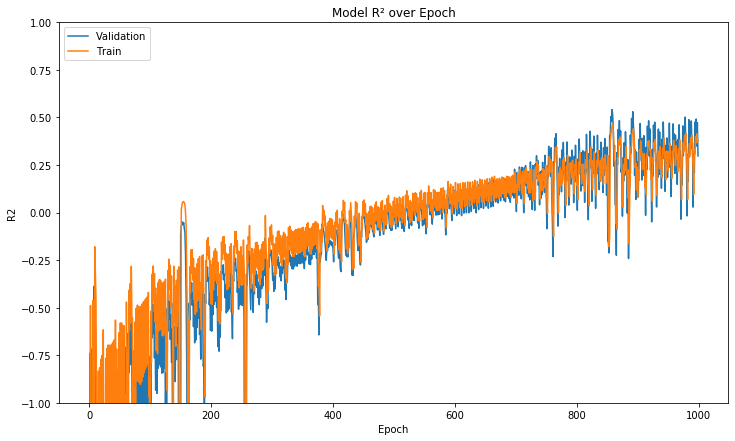

In [19]:
# Plot training & validation accuracy values
fig, ax = plt.subplots(figsize=(12,7))
_ = ax.plot(history.history['val_coeff_determination'])
_ = ax.plot(history.history['coeff_determination'])
plt.ylim(-1, 1)
plt.title('Model R² over Epoch')
plt.ylabel('R2')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')

##### 3.3.2 Activation maps

In [22]:
def plot_activation_map(X, y, model, layer_name, instance_id, ynames, analyte, figsize=(15,6)):
    instance_id = instance_id
    input_ = tf.convert_to_tensor(normalize(X[instance_id].reshape(1,-1)))
    grad_model = Model(inputs=model.input, 
                       outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, prediction = grad_model(input_)

    grads = tape.gradient(prediction, conv_output)[0]

    output = conv_output[0,:,:]
    guided_grads = tf.cast(conv_output[0,:,:] > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads
    weights = tf.reduce_mean(guided_grads, axis=0)

    cam = np.ones((output.shape[0]), dtype = np.float32)
    for i, w in enumerate(weights):
        cam += (w * output[:, i]).numpy()

    cam_resampled = resample(normalize(cam), X.shape[1]).reshape(-1,1)
    
    y_hats = model.predict(normalize(X)).ravel()
    y_trues = get_analyte(y, y_names, analyte)
   
    with plt.style.context(('ggplot')):
        fig = plt.figure(constrained_layout=True, figsize=figsize)
        gs = fig.add_gridspec(2, 3)

        ax1 = fig.add_subplot(gs[:, :1])
        ax1.set_title('y vs. y_predicted')
        ax1.scatter(y_hats, y_trues, c='black', s=10, edgecolors=None)
        ax1.scatter(y_hats[instance_id], y_trues[instance_id], c='orangered', s=300, label='Prediction')
        ax1.legend()

        ax2 = fig.add_subplot(gs[0, 1:])
        ax2.set_xlim(4000, 400)
        ax2.plot(X_names, X[instance_id], color='steelblue')
        ax2.set_title('Spectrum')

        ax3 = fig.add_subplot(gs[1, 1:])
        ax3.set_xlim(4000, 400)
        ax3.set_ylim(0, 1.05)
        ax3.plot(X_names, cam_resampled, color='green')
        ax3.set_title('Model attention')


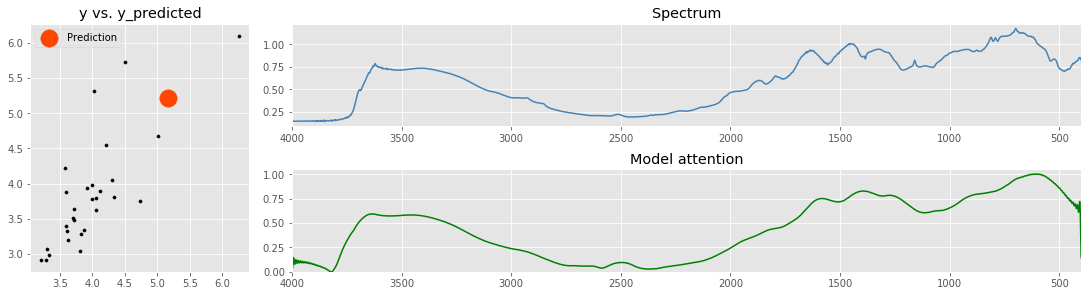

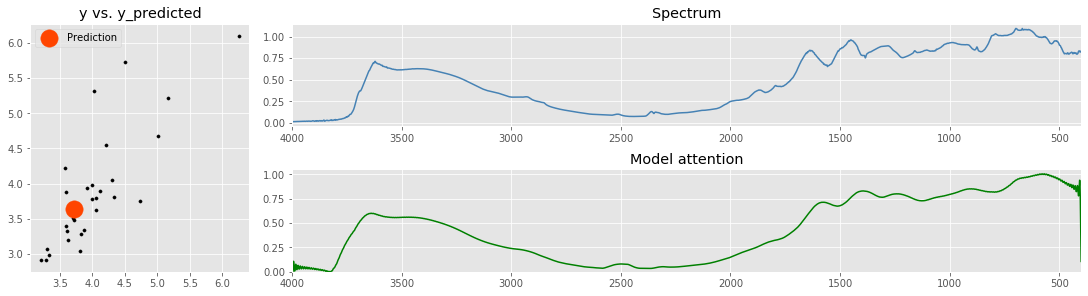

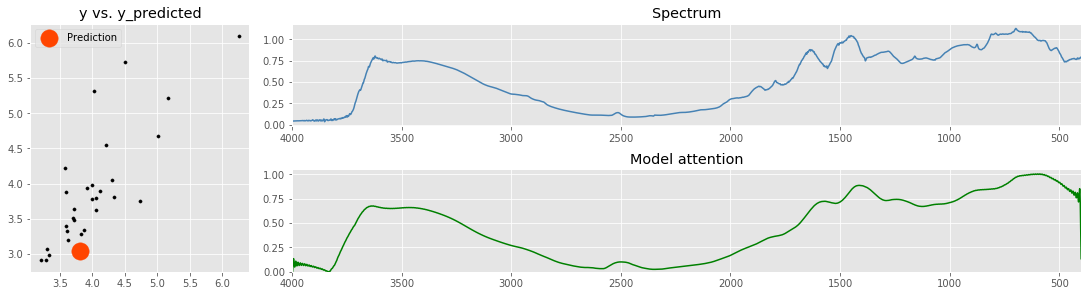

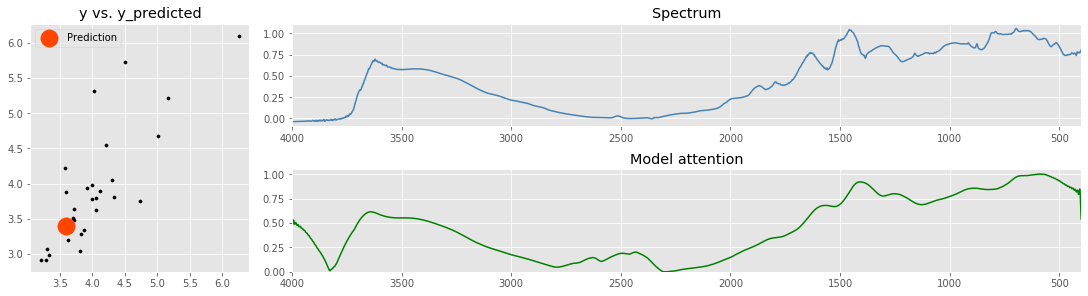

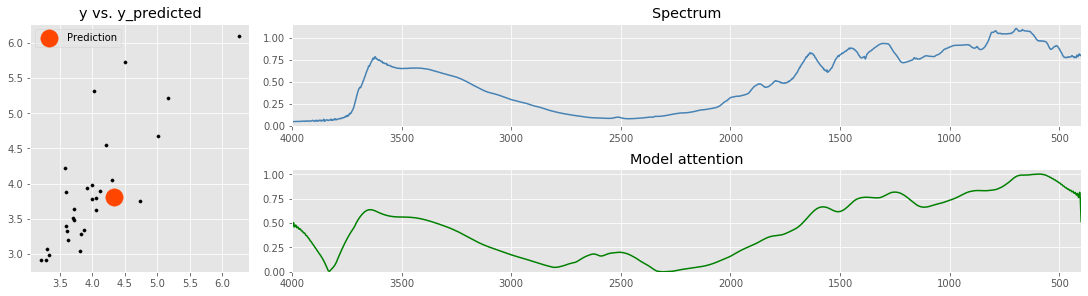

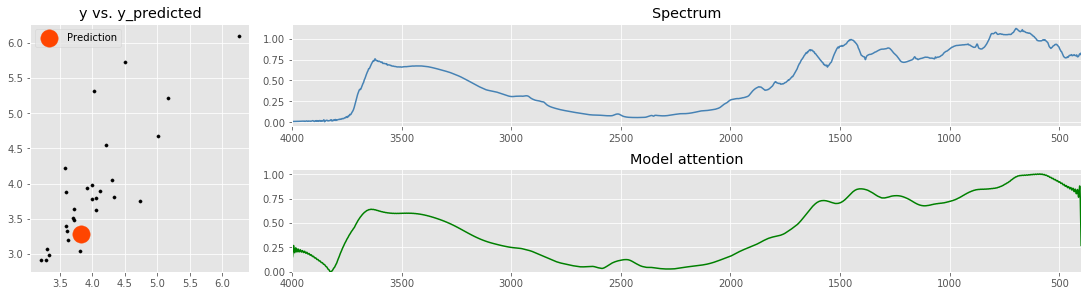

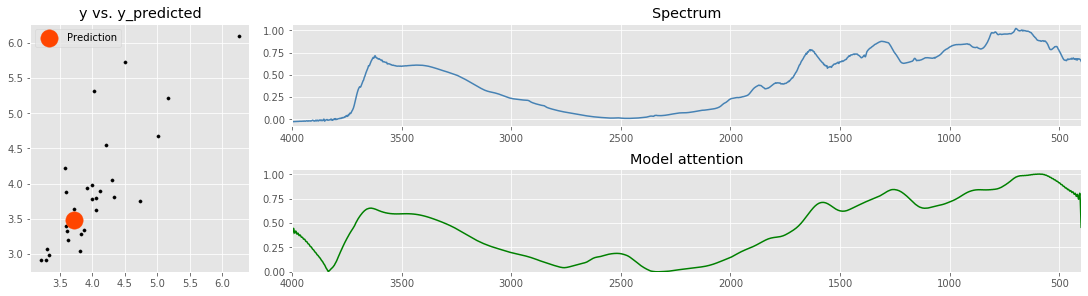

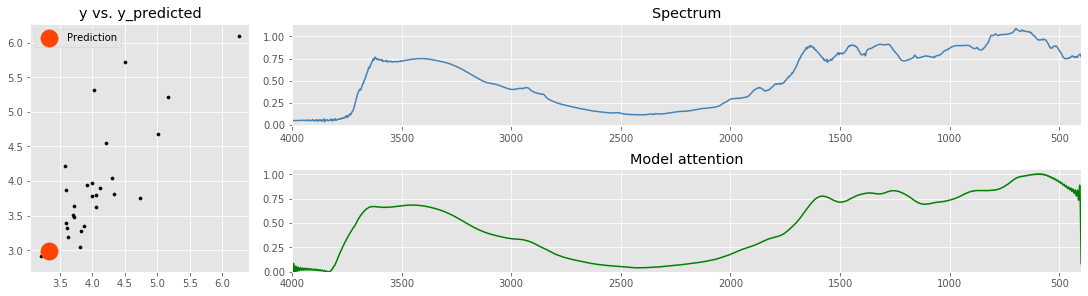

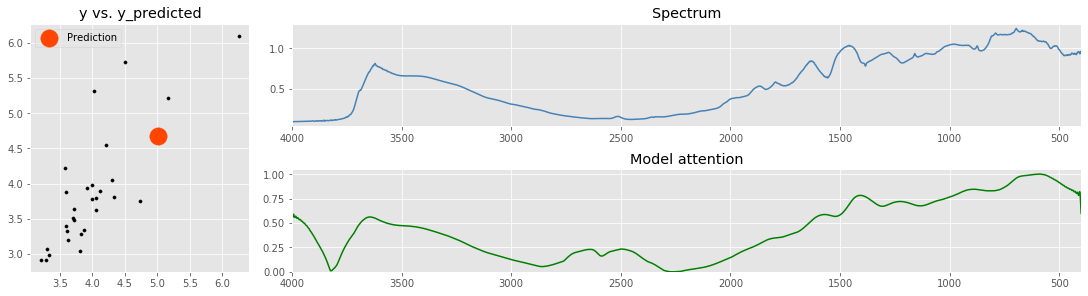

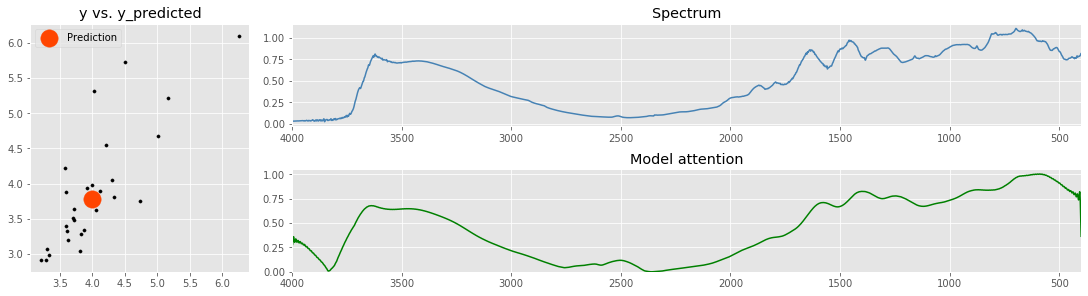

In [25]:
plt.rcParams.update({'figure.max_open_warning': 0})

for i in random.sample(range(X_train.shape[0]),10):
    plot_activation_map(X, y, model, 'conv1d_3', i, y_names, analyte, figsize=(15,4))

##### 3.3.3 Fitting and validating using K-fold cross-validation

In [ ]:
history = model.fit(normalize(X), get_analyte(y, y_names, 'Fe'), epochs=3000, validation_split=0.2)

In [ ]:
# Plot training & validation accuracy values
fig, ax = plt.subplots(figsize=(12,7))
_ = ax.plot(history.history['val_coeff_determination'])
_ = ax.plot(history.history['coeff_determination'])
plt.ylim(-10, 1)
plt.title('Model R² over Epoch')
plt.ylabel('R2')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')

### 4. Visualizing CNN [work in progress]

 * **Visualizing intermediate outputs (intermediate activations)**

In [ ]:
input_tensor = np.expand_dims(normalize(X_train)[1], axis=0)

layer_outputs = [layer.output for  layer in model.layers[:7]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(input_tensor)

In [ ]:
model.summary()

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
_ = ax.plot(X_names, normalize(X_train)[0])

In [ ]:
plt.hist(normalize(X_train)[0])

In [ ]:
n_layer = 1
activation_layer = np.squeeze(activations[n_layer], axis=0)

fig, ax = plt.subplots(figsize=(20,8))
_ = ax.plot(np.swapaxes(activation_layer,0,1).T)

In [ ]:
n_layer = 2
activation_layer = np.squeeze(activations[n_layer], axis=0)

fig, ax = plt.subplots(figsize=(20,8))
_ = ax.plot(np.swapaxes(activation_layer,0,1).T)

In [ ]:
n_layer = 3
activation_layer = np.squeeze(activations[n_layer], axis=0)

fig, ax = plt.subplots(figsize=(20,8))
_ = ax.plot(np.swapaxes(activation_layer,0,1).T)

In [ ]:
n_layer = 4
activation_layer = np.squeeze(activations[n_layer], axis=0)

fig, ax = plt.subplots(figsize=(20,8))
_ = ax.plot(np.swapaxes(activation_layer,0,1).T)

In [ ]:
n_layer = 5
activation_layer = np.squeeze(activations[n_layer], axis=0)

fig, ax = plt.subplots(figsize=(20,8))
_ = ax.plot(np.swapaxes(activation_layer,0,1).T)

In [ ]:
n_layer = 6
activation_layer = np.squeeze(activations[n_layer], axis=0)

fig, ax = plt.subplots(figsize=(20,8))
_ = ax.plot(np.swapaxes(activation_layer,0,1).T)

 * **Visualizing convnet filters**

In [ ]:
layer_name = 'conv1d'
filter_index = 0
layer_output = model.get_layer(layer_name).output

In [ ]:
layer_output.shape

In [44]:
K.mean(layer_output[:,:,filter_index])

NameError: name 'layer_output' is not defined

In [ ]:
model.get_layer(layer_name).get_weights()[0][:,:,0]

In [ ]:
# Visualizing first conv. layer kernel along filters 
def vis_kernels(model, layer_name, cmap='viridis', width=20, height=6):
    weights = model.get_layer(layer_name).get_weights()[0]
    shape = weights.shape
    weights = model.get_layer(layer_name).get_weights()[0].reshape(shape[-1], shape[0])
    fig, ax = plt.subplots(figsize=(width,height))
    _ = ax.imshow(weights, cmap=cmap)

In [ ]:
vis_kernels(model,'conv1d_120')

In [ ]:
 model.get_layer('conv1d_120').get_weights()[0].shape

In [ ]:
weights = model.get_layer('conv1d_120').get_weights()[0]
weights.reshape(weights.shape[-1], weights.shape[0]).shape

for i in range(20):
    fig, ax = plt.subplots(figsize=(20,4))
    _ = ax.plot(weights.reshape(weights.shape[-1], weights.shape[0])[i])

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
_ = ax.plot(X_names, np.random.random(7467))

In [ ]:
random_input =  np.random.random(7467)
random_input.reshape(1,-1).shape

In [ ]:
# https://keras.io/getting-started/faq/#how-can-i-visualize-the-output-of-an-intermediate-layer
# Option 1: with a Sequential model
get_1st_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])

get_1st_layer_output([random_input.reshape(1,-1)])[0].shape

# Option 2: by creating an intermediate model
layer_name = 'conv1d'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
#intermediate_layer_model.predict(random_input.reshape(1,-1)).shape

In [ ]:
# http://blog.ai.ovgu.de/posts/jens/2019/001_tf20_pitfalls/index.html
input_ = tf.convert_to_tensor(random_input.reshape(1,-1), dtype='float64')
layer_name = 'conv1d_121'
filter_nb = 2
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_layer_model(input_)[:,:,0]

#print(input_)
for i in range(100):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(input_)
        output = intermediate_layer_model(input_)[:,:,filter_nb]
        loss = tf.reduce_mean(output)
        grads_value = tape.gradient(loss, input_)
        grads_value /= (K.sqrt(K.mean(K.square(grads_value))) + 1e-5)
        #print(grads_value)
        input_ += grads_value
        #print(input_.numpy().reshape(-1)[0])

fig, ax = plt.subplots(figsize=(20,8))
_ = ax.plot(X_names,normalize(input_.numpy().reshape(-1)))
_ = ax.plot(X_names,normalize(X_train)[0])